In [1]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import pylab as pb
import GPy
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import pickle

In [2]:
weather = pd.read_csv("weather.Ulsan.6hr.1980-2017.csv")
weather = weather[["time", "pressure", "wind_speed", "precipitation", "humidity", "temperature"]]
weather.drop(weather.index[0:50500], 0, inplace=True)

In [3]:

weather.describe()

,time,pressure,wind_speed,precipitation,humidity,temperature
count,5.020000e+03,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000
mean,2.015818e+09,1015.941474,2.176912,0.850936,66.422649,14.941135
std,1.005346e+06,7.674471,1.212318,5.055697,22.419182,8.849070
min,2.014073e+09,989.200000,0.000000,0.000000,8.000000,-10.000000
25%,2.015060e+09,1009.900000,1.200000,0.000000,48.775000,7.700000
50%,2.016041e+09,1016.100000,1.900000,0.000000,69.500000,16.100000
75%,2.017022e+09,1022.000000,2.900000,0.000000,85.500000,22.100000
max,2.017123e+09,1035.800000,8.800000,180.000000,100.000000,35.600000


In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 50500 to 55519
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           5020 non-null   int64  
 1   pressure       5020 non-null   float64
 2   wind_speed     5020 non-null   float64
 3   precipitation  5020 non-null   float64
 4   humidity       5020 non-null   float64
 5   temperature    5020 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 274.5 KB


In [5]:
weather["time"] = list(range(len(weather)))
data = np.array(weather)
data.shape

(5020, 6)

In [6]:
X = data[:, :-1]
X = X - X.min()
X = 2 * (X / X.max()) - 1
y = data[:, -1].reshape(-1, 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [8]:
kern = GPy.kern.Exponential(5, lengthscale=1) * GPy.kern.RBF(5, lengthscale=1)

In [9]:
%%time
model = GPy.models.GPRegression(X_train, y_train, kern)
model.optimize()


Wall time: 5min 2s


In [10]:
%%time
#Save a model
file = open('model', 'wb')
pickle.dump(model, file)
file.close()

Wall time: 908 ms


In [11]:
%%time
# open a model
file = open('model', 'rb')
mod = pickle.load(file)
file.close()
display(mod)
mean, variance = mod.predict(X_test)
print("R2 Score for temperature: ", round(sm.r2_score(mean, y_test), 2))
print("Predicted mean temperture:",mean.mean())
print("Average Predicted Temperature:",round(mean.mean(),2))
print("Minumum Predicted Temperature:",round(mean.min(),2))
print("Maximum Predicted Temperature:",round(mean.max(),2))


GP_regression.,value,constraints,priors
mul.Exponential.variance,87.36216848840314,+ve,
mul.Exponential.lengthscale,4.886045274003716,+ve,
mul.rbf.variance,87.36216848841397,+ve,
mul.rbf.lengthscale,0.19200562132432747,+ve,
Gaussian_noise.variance,4.7242218181088696e-30,+ve,


R2 Score for temperature:  0.94
Predicted mean temperture: 14.674725281927081
Average Predicted Temperature: 14.67
Minumum Predicted Temperature: -4.42
Maximum Predicted Temperature: 32.7
Wall time: 6.25 s


Mean absolute error(MAE) = 1.5
Mean squared error(MSE) = 4.54
Root mean square error(RMSE) :  2.13
Median absolute error(MDAE) = 1.07
Explain variance score(VS) = 0.94
R2 score = 0.94


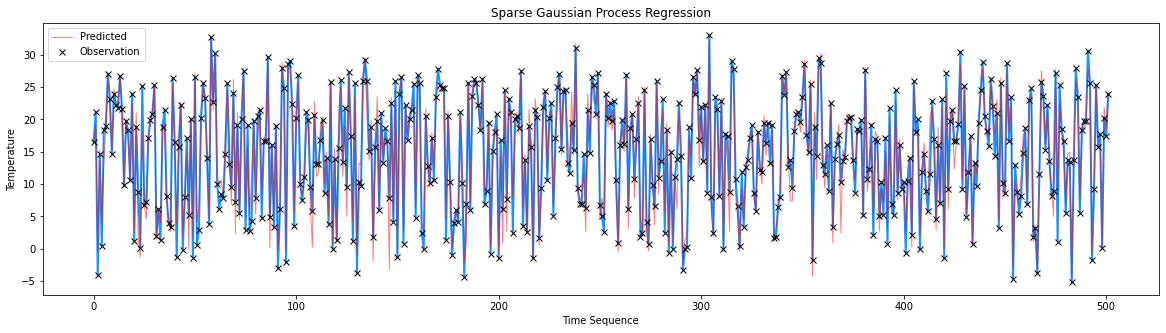

In [12]:
fig, ax = pb.subplots(figsize=[20, 5])
pb.plot(y_test,color="dodgerblue",lw=2, alpha=1)
pb.plot(mean,color="red",lw=1, alpha=0.5,label="Predicted")
pb.plot(y_test,"x", color='black', label="Observation", alpha=1)

pb.xlabel("Time Sequence")
pb.ylabel("Temperature")
pb.legend()
pb.title("Sparse Gaussian Process Regression")
ax.legend()
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(y_test, mean), 2)) 
print("Mean squared error(MSE) =", round(sm.mean_squared_error(y_test, mean,squared=True), 2)) 
print("Root mean square error(RMSE) : ", round(np.sqrt(sm.mean_squared_error(mean, y_test)), 2))
print("Median absolute error(MDAE) =", round(sm.median_absolute_error(y_test, mean), 2)) 
print("Explain variance score(VS) =", round(sm.explained_variance_score(y_test , mean), 2)) 
print("R2 score =", round(sm.r2_score(y_test, mean), 2))

In [13]:
print("Accuracy Score for temperature: ", round(sm.r2_score(mean, y_test), 2))
print("Mean square error(MSE): ",round(sm.mean_squared_error(mean, y_test, squared=True), 2))
print("Root mean square error(RMSE) : ", round(np.sqrt(sm.mean_squared_error(mean, y_test)), 2))


Accuracy Score for temperature:  0.94
Mean square error(MSE):  4.54
Root mean square error(RMSE) :  2.13


In [14]:
%%time
Z = 10
model2 = GPy.models.SparseGPRegression(X_train, y_train, kern, num_inducing=Z)
model2.optimize()


Wall time: 3.55 s


In [15]:
%%time
#Save a model
file2 = open('model2', 'wb')
pickle.dump(model2, file2)
file2.close()

Wall time: 0 ns


In [16]:
%%time
# open a model
file2 = open('model2', 'rb')
mod2 = pickle.load(file2)
file2.close()
mean_s, variance_s = mod2.predict(X_test)
print("R2 Score for temperature: ", round(sm.r2_score(mean_s, y_test), 2))
print("Predicted mean temperture:",mean_s.mean())

R2 Score for temperature:  0.8
Predicted mean temperture: 14.819790540191903
Wall time: 33.6 ms


sparse_gp.,value,constraints,priors
inducing inputs,"(10, 5)",,
mul.Exponential.variance,51.12978135353695,+ve,
mul.Exponential.lengthscale,143.96068482711013,+ve,
mul.rbf.variance,51.12978135354776,+ve,
mul.rbf.lengthscale,40.391093024939714,+ve,
Gaussian_noise.variance,14.333643238599379,+ve,


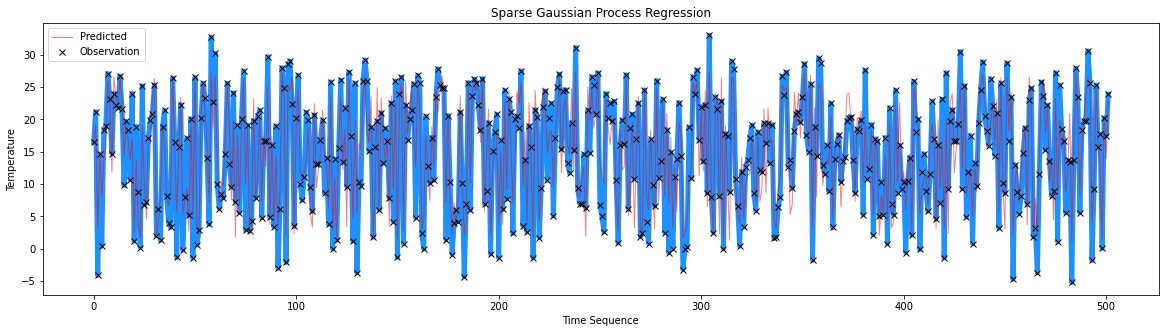

In [17]:
display(mod2)
fig, ax = pb.subplots(figsize=[20, 5])
pb.plot(y_test, color="dodgerblue", lw=5, alpha=1)
pb.plot(mean_s, color="red", lw=1, alpha=0.5, label="Predicted")
pb.plot(y_test, "x", color='black', label="Observation", alpha=1)

pb.xlabel("Time Sequence")
pb.ylabel("Temperature")
pb.legend()
pb.title("Sparse Gaussian Process Regression")
pb.show()


In [18]:
mod2?

Type:            SparseGPRegression
String form:    
           Name : sparse_gp
           Objective : 12726.260183003506
           Number of Parameters : 55
           Number of Optimization <...>
           Gaussian_noise.variance      |  14.333643238599379  |      +ve      |
File:            c:\users\yobsan\anaconda3\lib\site-packages\gpy\models\sparse_gp_regression.py
Docstring:      
    Gaussian Process model for regression

    This is a thin wrapper around the SparseGP class, with a set of sensible defalts

    :param X: input observations
    :param X_variance: input uncertainties, one per input X
    :param Y: observed values
    :param kernel: a GPy kernel, defaults to rbf+white
    :param Z: inducing inputs (optional, see note)
    :type Z: np.ndarray (num_inducing x input_dim) | None
    :param num_inducing: number of inducing points (ignored if Z is passed, see note)
    :type num_inducing: int
    :rtype: model object

    .. Note:: If no Z array is passed, num_inducin

predicted mean : 14.819790540191903
Minimum predicted : 1.2260919597854871
Maximum predicted : 27.276138971077803
Mean absolute error(MAE) = 2.8
Mean squared error(MSE) = 12.14
Root mean square error(RMSE) :  3.48
Median absolute error(MDAE) = 2.42
Explain variance score(VS) = 0.84
R2 score = 0.84


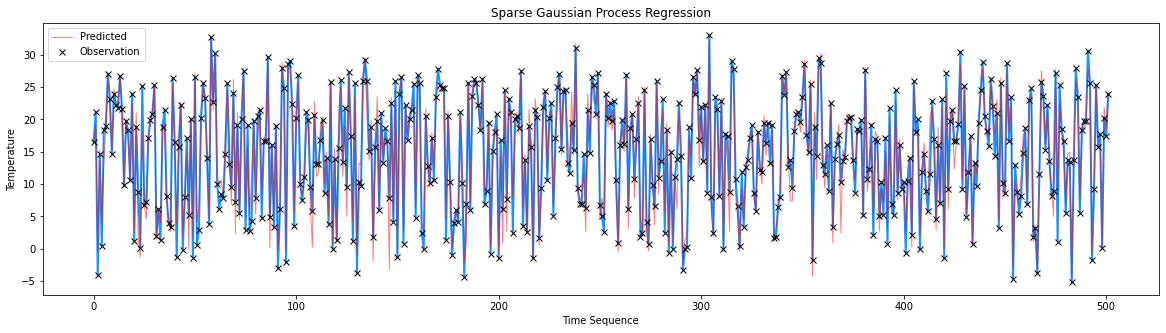

In [21]:
print("predicted mean :",np.mean(mean_s))
print("Minimum predicted :",np.min(mean_s))
print("Maximum predicted :",np.max(mean_s))
fig, ax = pb.subplots(figsize=[20, 5])
pb.plot(y_test,color="dodgerblue",lw=2, alpha=1)
pb.plot(mean,color="red",lw=1, alpha=0.5,label="Predicted")
pb.plot(y_test,"x", color='black', label="Observation", alpha=1)

pb.xlabel("Time Sequence")
pb.ylabel("Temperature")
pb.legend()
pb.title("Sparse Gaussian Process Regression")
ax.legend()
print("Mean absolute error(MAE) =", round(sm.mean_absolute_error(y_test, mean_s), 2)) 
print("Mean squared error(MSE) =", round(sm.mean_squared_error(y_test, mean_s,squared=True), 2)) 
print("Root mean square error(RMSE) : ", round(np.sqrt(sm.mean_squared_error(mean_s, y_test)), 2))
print("Median absolute error(MDAE) =", round(sm.median_absolute_error(y_test, mean_s), 2)) 
print("Explain variance score(VS) =", round(sm.explained_variance_score(y_test , mean_s), 2)) 
print("R2 score =", round(sm.r2_score(y_test, mean_s), 2))